# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2022 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 1.5.2022

## Initialisation

In [1]:
%matplotlib inline 

In [2]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

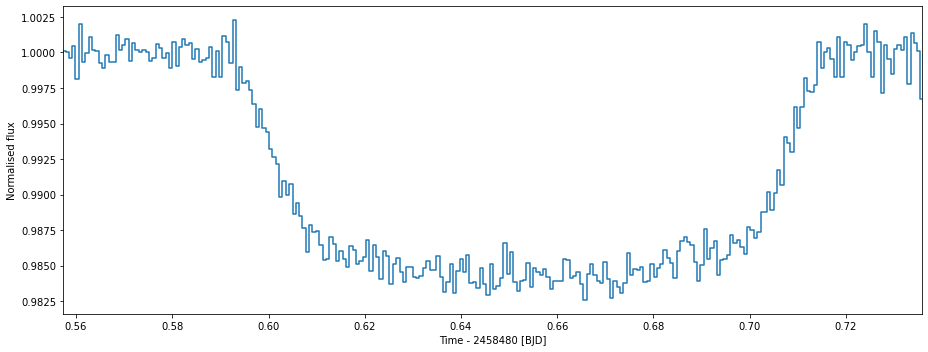

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [6]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

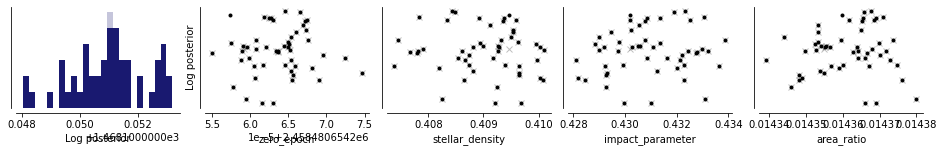

In [10]:
lpf.optimize_global(niter=500, npop=50)

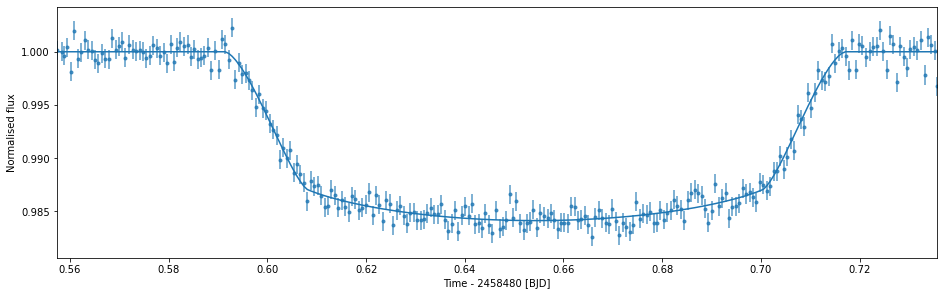

In [11]:
lpf.plot_light_curve();

In [12]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

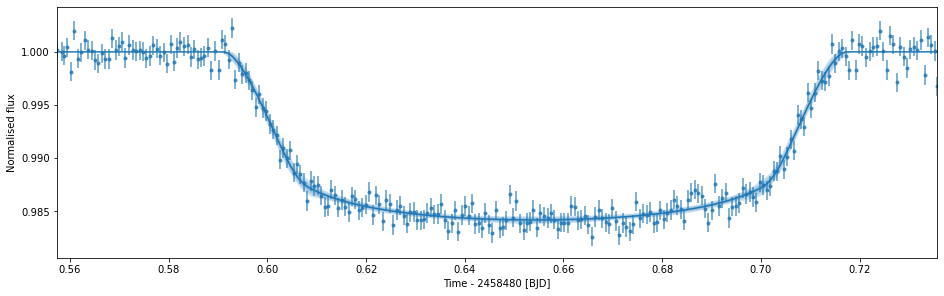

In [13]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

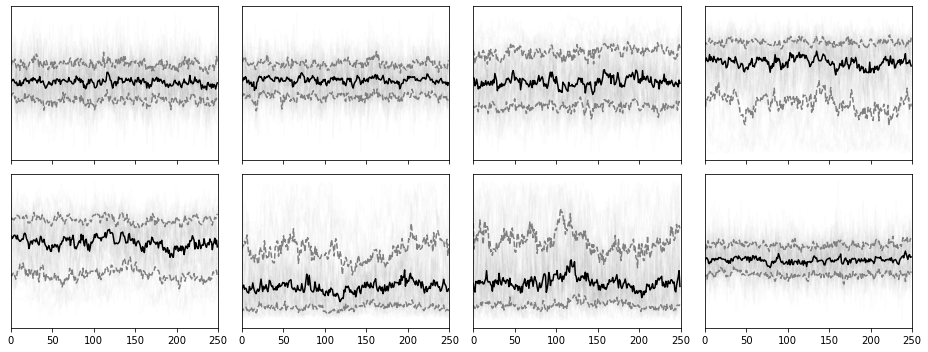

In [14]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [15]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [16]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

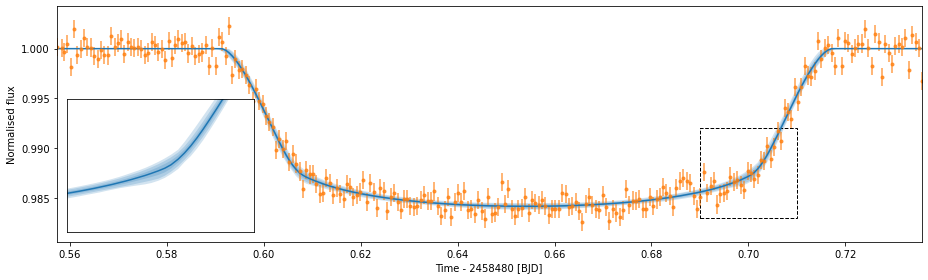

In [17]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [18]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4362,0.3300,0.0139,0.3281,0.3319,-3.0415,0.1180,3.0150,1.4599,0.1258,0.0948
std,1.6220e-04,1.1031e-09,0.0366,0.1241,0.0005,0.2019,0.2320,0.0193,0.0019,0.0843,0.0437,0.0010,0.0026
min,2.4585e+06,1.0914e+00,0.3329,0.0002,0.0126,0.0491,0.0003,-3.1171,0.1123,2.7572,1.3672,0.1225,0.0873
25%,2.4585e+06,1.0914e+00,0.4084,0.2576,0.0136,0.1704,0.1484,-3.0547,0.1166,2.9518,1.4267,0.1251,0.0927
50%,2.4585e+06,1.0914e+00,0.4338,0.3632,0.0140,0.2757,0.2736,-3.0419,0.1183,3.0116,1.4501,0.1258,0.0945
75%,2.4585e+06,1.0914e+00,0.4641,0.4242,0.0143,0.4360,0.4717,-3.0287,0.1195,3.0803,1.4871,0.1265,0.0968
max,2.4585e+06,1.0914e+00,0.5314,0.5585,0.0151,0.9986,0.9996,-2.9442,0.1227,3.2225,1.5707,0.1305,0.1013


<AxesSubplot:>

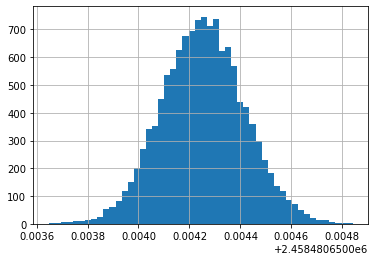

In [19]:
df.tc.hist(bins=50)

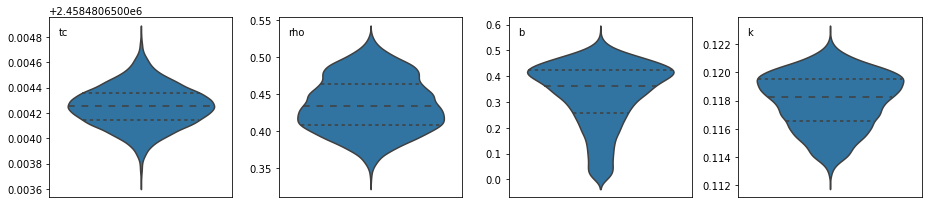

In [20]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

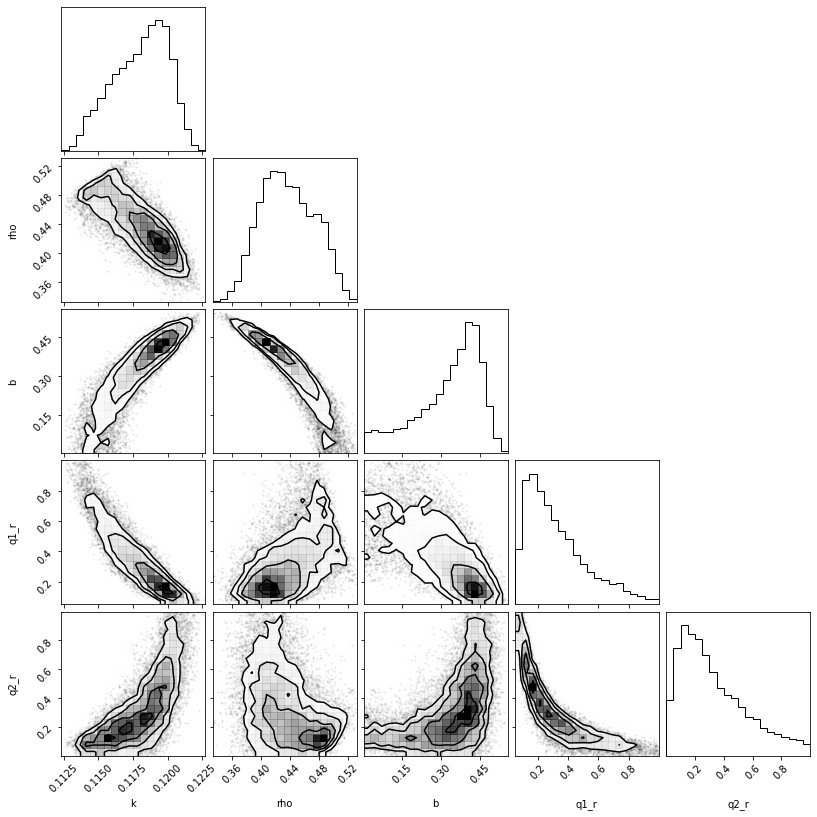

In [21]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols], labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere ;)) Give the answer in Jupiter radii.

In [60]:
import numpy as np
medk = np.median(df.k)
perc = np.percentile(df.k,[16., 84.])
print('Median k = ', round(medk,4))
print('16% & 84% percentiles: ', round(perc[0],4), round(perc[1],4))
# Equivalent to mean -/+ sigma in Gaussian distribution

rstar = 1.66 * 6.96E5 # Star radius (km) from Collins+2017 (+/- 0.045 Rsun)
rjupi = 6.99E4 # Jupiter radius (km)
soj = rstar / rjupi
print('Median planet radius = ', round(medk*soj,2), ' [Jupiter radius]')
print('68% confidence interval = ', round(perc[0]*soj,2), '-', round(perc[1]*soj,2), ' [RJ]')
print('Add 3% uncertainty (0.06 RJ) due to the accuracy of the stellar radius determination!')
print('Collins+2017 gives 1.90 +/- 0.06 RJ, which is compatible.')
print('')

mrho = np.median(df.rho)
prho = np.percentile(df.rho,[16., 84.])
print('Median density = ', round(mrho,3), '[g/cm3]')
print('16% & 84% percentiles: ', round(prho[0],3), round(prho[1],3), '[g/cm3]')
# Equivalent to mean -/+ sigma in Gaussian distribution


Median k =  0.1183
16% & 84% percentiles:  0.1158 0.12
Median planet radius =  1.96  [Jupiter radius]
68% confidence interval =  1.91 - 1.98  [RJ]
Add 3% uncertainty (0.06 RJ) due to the accuracy of the stellar radius determination!
Collins+2017 gives 1.90 +/- 0.06 RJ, which is compatible.

Median density =  0.434 [g/cm3]
16% & 84% percentiles:  0.398 0.478 [g/cm3]


2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

- According to Bergfors+2013, WASP-12 is a spectral type G0 main sequence star (G0V). Table 15.8 in Allen's astrophysical quatities (2002) gives:

    $\log \left( {\frac{{{{\bar \rho }_{G0V}}}}{{{{\bar \rho }_ \odot }}}} \right) =  - 0.1\,\, \to \,\,{\bar \rho _{G0V}} \approx 0.79{\bar \rho _ \odot } = 1.1\,{\rm{g}} \cdot {\rm{c}}{{\rm{m}}^{{\rm{ - 3}}}}$,
    
    which is way larger that the estimate from the transit modeling. However, the G0V classification is not supported by spectroscopic measurements from Ebb+2009, which yield an effective temperature of 6300 K (vs. 5940 for a typical G0V star). Matching the stellar evolution models of Girardi+2000 to their observations, Ebb+ suggest an evolved late F-type star which has abandoned the ZAMS but not reached the hydrogen shell burning phase. The best agreement is for age 2 Gyr and mass 1.33 $M_{Sun}$, corresponding to $R_*/M_*^{1/3}$ = 1.45 (in solar units). Thus, the density would be 0.33 $\rho_{Sun}$ = 0.46 $g/cm^3$, more inline with the transit modeling. 

3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

- I can think of two issues:

    1) If the selection of new proposals for the MCMC uses a function that does not take into account the correlation, this will lead to increased rejection rates and the convergence will be slow.
    
    2) It introduces some level of degeneracy in the solution, because errors due to one parameter can be compesated for by changing another. This makes it more difficult to determine a single set of physical parameters compatible with the observations. Instead, a familiy of solutions with similar performance is obtained.


---
<center>&copy; Hannu Parviainen 2014&ndash;2022</center>